In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [1]:
import ot

/Users/peter/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Power Plant Data.csv')

df_sorted = df.sort_values(by='AT', ascending=True).reset_index(drop=True)

#  Define the Split Cutoff (70% Source / 30% Target)
split_idx = int(0.7 * len(df_sorted))

#  Create the Partition
# Source (Train): The coldest 70%
df_source = df_sorted.iloc[:split_idx]
Xs = df_source[['AT', 'V', 'AP', 'RH']].values
Ys = df_source['PE'].values

In [6]:
# Target (Test): The hottest 30%
df_target = df_sorted.iloc[split_idx:]
Xt = df_target[['AT', 'V', 'AP', 'RH']].values
Yt = df_target['PE'].values

# 5. Normalize (CRITICAL for Optimal Transport)
# OT is sensitive to scale. You must normalize based on the SOURCE stats.
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)
Xt_scaled = scaler.transform(Xt)  # Apply source scaling to target

In [ ]:
from numpyro.infer import Predictive

In [63]:
# 1. Compute Sinkhorn (Same as before)
# 1. Setup Uniform Distributions (The "Prior" belief)
n_source = len(Xs_scaled)
n_target = len(Xt_scaled)
a = np.ones(n_source) / n_source
b = np.ones(n_target) / n_target

# 2. Compute Cost Matrix (Squared Euclidean)
M = ot.dist(Xs_scaled, Xt_scaled, metric='sqeuclidean')

# 3. Compute Unbalanced Transport Plan
# reg = 0.1 (Entropy), reg_m = 1.0 (Marginal Relaxation)
gamma_unbalanced = ot.unbalanced.sinkhorn_unbalanced(
    a, b, M, reg=0.05, reg_m=1.0)

# 4. Extract Importance Weights
# Summing over the target columns tells us how much "mass" each source point contributed
# We multiply by n_source to center the weights around 1.0
weights = np.sum(gamma_unbalanced, axis=1) * n_source

# 5. Sanity Check
print(f"Max Weight: {weights.max():.2f}")  # Should be > 1 (Useful points)
print(f"Min Weight: {weights.min():.2f}")  # Should be < 1 (Useless points)

Max Weight: 6.09
Min Weight: 0.00


In [64]:
def robust_weighted_regression(X, Y=None, weights=None):
    n_obs, n_features = X.shape

    # --- FIX STARTS HERE ---
    # 1. Determine Prior Mean safely
    # If we are training, use data statistics. If predicting (Y=None), use defaults.
    if Y is not None:
        y_mean_prior = jnp.mean(Y)
        y_scale_prior = jnp.std(Y)
    else:
        # Defaults for prediction (doesn't impact posterior, just placeholder for shape)
        y_mean_prior = 0.0
        y_scale_prior = 100.0

    # 2. Intercept (Alpha)
    # Now use the safe variable 'y_mean_prior'
    alpha = numpyro.sample('alpha', dist.Normal(y_mean_prior, 100.0))

    # 3. Sigma
    sigma = numpyro.sample('sigma', dist.HalfNormal(y_scale_prior))
    # --- FIX ENDS HERE ---

    # Weights (Beta)
    beta = numpyro.sample('beta', dist.Normal(0.0, 1.0).expand([n_features]))

    # Degrees of freedom for Student-T
    nu = numpyro.sample('nu', dist.Gamma(2.0, 0.1))

    # Deterministic Mean
    mu = alpha + jnp.dot(X, beta)

    # Likelihood
    with numpyro.plate('data', n_obs):
        obs_dist = dist.StudentT(nu, mu, sigma)

        # Sample (Condition on Y if it exists)
        numpyro.sample('obs', obs_dist, obs=Y)

        # Weighting (Only if we have weights AND data)
        if weights is not None and Y is not None:
            log_prob = obs_dist.log_prob(Y)
            numpyro.factor('obs_weighting', (weights - 1) * log_prob)

In [ ]:
import jax.random

In [ ]:
# --- BASELINE: Naive Training ---
# This defaults to standard Bayesian Robust Regression.

X_train = jnp.array(Xs_scaled)
Y_train = jnp.array(Ys)

mcmc_baseline = MCMC(
    NUTS(robust_weighted_regression),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2
)

print("Starting Baseline (Naive) Sampling...")
mcmc_baseline.run(
    jax.random.PRNGKey(99),
    X=X_train,  # Xs_scaled
    Y=Y_train,  # Ys
    weights=None  # difference
)

baseline_samples = mcmc_baseline.get_samples()

/var/folders/zl/1dq1dqcj2d37cy0lyvfcht340000gn/T/ipykernel_14132/2500154769.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_baseline = MCMC(


Starting Baseline (Naive) Sampling...


sample: 100%|██████████| 3000/3000 [00:09<00:00, 305.98it/s, 7 steps of size 4.05e-01. acc. prob=0.93] 


In [38]:
# Predict on the Target (Xt) using Baseline parameters
predictive_baseline = Predictive(robust_weighted_regression, baseline_samples)

predictions_baseline = predictive_baseline(
    jax.random.PRNGKey(2),
    X=Xt_scaled_jax,
    Y=None
)

Y_pred_baseline = predictions_baseline['obs']

# Calculate Baseline Statistics
y_mean_base = np.mean(Y_pred_baseline, axis=0)
y_lower_base = np.percentile(Y_pred_baseline, 2.5, axis=0)
y_upper_base = np.percentile(Y_pred_baseline, 97.5, axis=0)

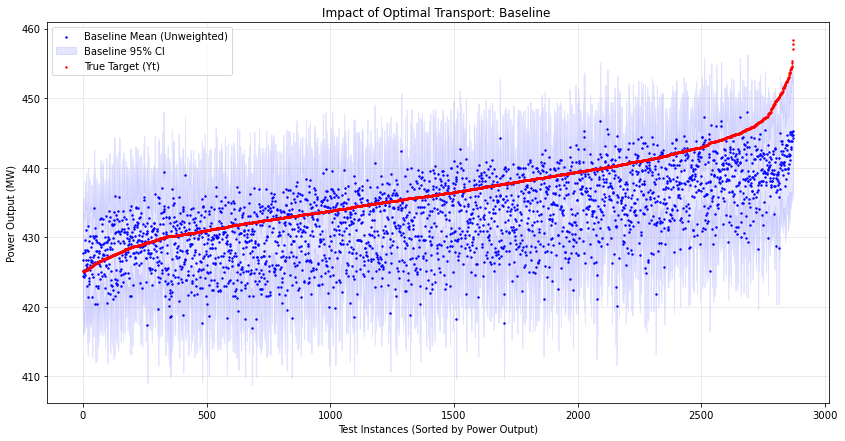

In [43]:
plt.figure(figsize=(14, 7))

# Sort by True Output (Yt) for the S-curve
sort_idx = np.argsort(Yt)

# --- 1. PLOT BASELINE (Naive) ---
# We use a dashed line for the mean to distinguish it
plt.scatter(range(len(Yt)), y_mean_base[sort_idx], color='blue', s=2, zorder=10, label='Baseline Mean (Unweighted)')
plt.fill_between(range(len(Yt)), y_lower_base[sort_idx], y_upper_base[sort_idx],
                 color = 'blue', alpha=0.1, label='Baseline 95% CI')

# --- 2. PLOT PROPOSED (Weighted) ---
# We use a solid line for your method
#plt.plot(range(len(Yt)), y_mean_sorted, color='green',
#         linewidth=2, label='OT-Weighted Mean (Ours)')
#plt.fill_between(range(len(Yt)), y_lower_sorted, y_upper_sorted,
#                 color='green', alpha=0.4, label='OT-Weighted 95% CI')

# --- 3. PLOT TRUTH ---
plt.scatter(range(len(Yt)), Yt[sort_idx], color='red',
            s=2, zorder=10, label='True Target (Yt)')

# Formatting
plt.title("Impact of Optimal Transport: Baseline ")
plt.xlabel("Test Instances (Sorted by Power Output)")
plt.ylabel("Power Output (MW)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()